In [32]:
import json
import pandas as pd
import numpy as np
from pprint import pprint
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
#stopwords = stopwords.words('english')
import gensim
import seaborn as sns
sns.set()
import nltk
import plotly.figure_factory as ff
from scipy.cluster import hierarchy
import warnings
import networkx as nx
warnings.filterwarnings('ignore')

In [33]:
with open("./data/windows/windows_data.txt", "r") as read_file:
    data = json.load(read_file)

In [34]:
data['commands'][470]

{'commands': 'ntfrsutl',
 'description': 'Dumps the internal tables, thread, and memory information for the NT File Replication Service (NTFRS) from both the local and remote servers. The recovery setting for NTFRS in Service Control Manager (SCM) can be critical to locating and keeping important log events on the computer. This tool provides a convenient method of reviewing those settings.',
 'syntax': ['ntfrsutl[idtable|configtable|inlog|outlog][<computer>]',
  'ntfrsutl[memory|threads|stage][<computer>]',
  'ntfrsutl ds[<computer>]',
  'ntfrsutl [sets][<computer>]',
  'ntfrsutl [version][<computer>]',
  'ntfrsutl poll[/quickly[=[<n>]]][/slowly[=[<n>]]][/now][<computer>]'],
 'parameters': {'idtable': 'Specifies the ID table.',
  'configtable': 'Specifies the FRS configuration table.',
  'inlog': 'Specifies the inbound log.',
  'outlog': 'Specifies the outbound log.',
  '<computer>': 'Specifies the computer.',
  'memory': 'Specifies the memory usage.',
  'threads': 'Specifies the memo

In [35]:
def get_max_sim_comds(sim_df, threshold):
    cols = list(sim_df.columns)
    simi = dict()
    for c in cols:
        vv = sim_df.loc[sim_df[c]>=threshold][[c]].index.values
        simi[c] = []
        for v in vv:  
            if v!=c and v not in simi.keys():  
                simi[c].append(v)
    new_sim = {k: v for k, v in simi.items() if len(simi[k])>0}
    data_items = new_sim.items()
    data_list = list(data_items)
    
    df = pd.DataFrame(data_list, columns=['comm1', 'comm2'])
    lst_col = 'comm2'
    
    r = pd.DataFrame({col:np.repeat(df[col].values, df[lst_col].str.len())
      for col in df.columns.drop(lst_col)}).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns]

    r['sim_score'] = ''
    
    for i in range(len(r['comm1'])):
        first_comm = r.loc[i][0]
        second_comm = r.loc[i][1]
        sim_val = sim_df.loc[[first_comm]][second_comm][0]
        r.loc[i, 'sim_score'] =  round(sim_val,5)
    return r, new_sim


In [36]:
def create_matrix_high_sim_comds(sim_df, r):
    cols = np.unique(r['comm1'].values)
    indx = np.unique(r['comm2'].values)

    new_df = pd.DataFrame(columns=cols, index=indx)
    
    new_df = new_df.loc[:,~new_df.columns.duplicated()]
    new_df = new_df.loc[~new_df.index.duplicated(keep='first')]
    new_cols = new_df.columns
    new_indx = new_df.index
    
    for col in new_cols:
        for indx in new_indx:
            val = round(sim_df.loc[[col]][indx][0],5)
            new_df.loc[indx, col] = val
    return new_df

In [37]:
def plot_sim_heatmap(new_df):
    score_values = new_df.to_numpy('float').tolist()

    fig, ax = plt.subplots(1,1)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    im = ax.imshow(score_values)
    x_axis_values = list(new_df.columns.values)
    y_axis_values = list(new_df.index.values)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(x_axis_values)))
    ax.set_yticks(np.arange(len(y_axis_values)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x_axis_values)
    ax.set_yticklabels(y_axis_values)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(),rotation=0, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    ax.set_title("")

    #plt.savefig('./results/windows/wind_pars_with_high_sim.png')
    plt.show()

In [38]:
def max_sim_all_cmds(df):
    id_ar = np.identity((len(df.columns)))
    temp = df - id_ar
    temp2 = temp[temp.idxmax()]
    a = temp.max()
    b = temp.idxmax()
    c = dict(a)
    d = dict(b)
    sim_sc = []
    for k, v in c.items():
        sim_sc.append([k, d[k], c[k]] )
    sim_sc_pd = pd.DataFrame(sim_sc, columns=['first', 'second', 'score'])
    asc = sim_sc_pd.sort_values('score', ascending=False)
    figure = plt.figure(figsize=(20, 12))
    plt.plot(asc['first'], asc['score'])
    plt.xticks(rotation=90)
    #plt.savefig('./results/windows/wind_pars_max_sim_per_command.png')

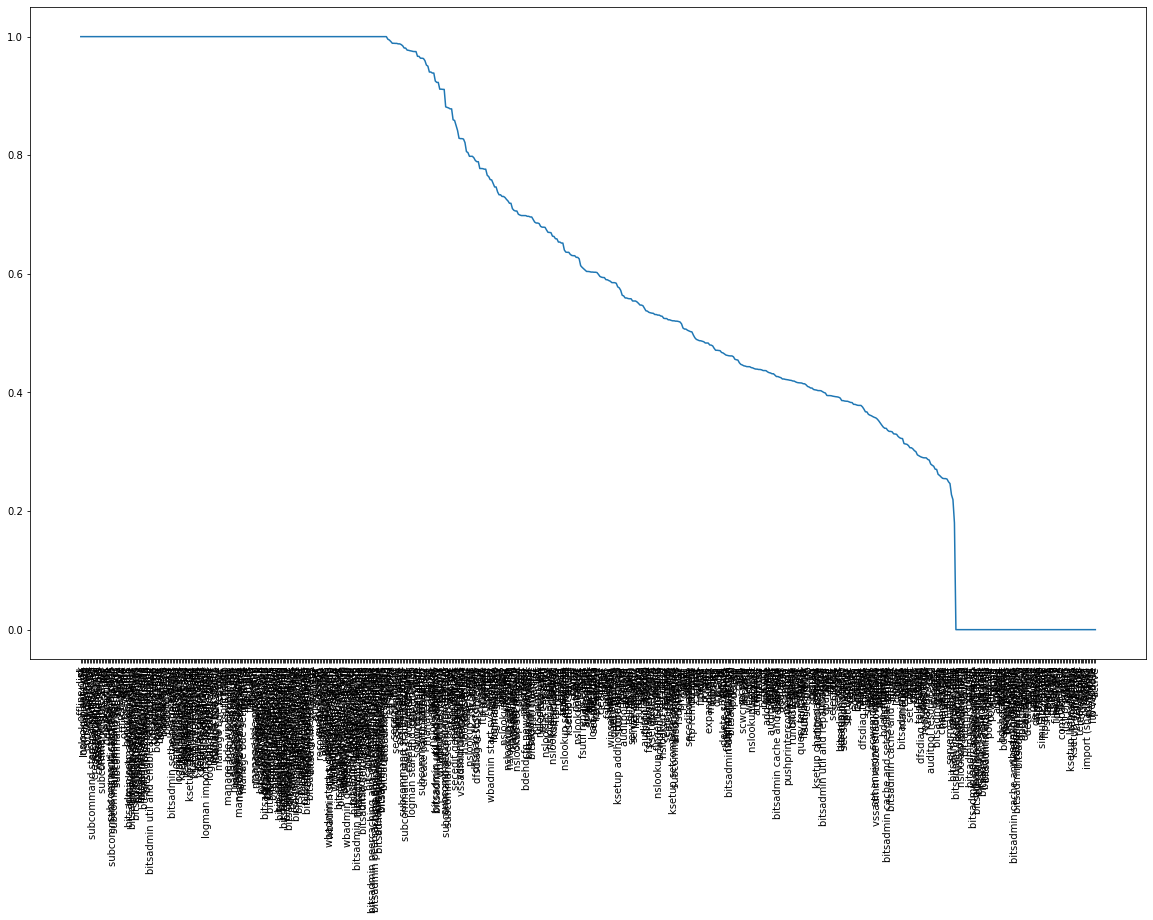

In [20]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

wind_pars_linear_sum = pd.read_csv('./data/windows/windows_pars_sim_df.csv', index_col=0)
max_sim_all_cmds(wind_pars_linear_sum)

In [39]:
wind_pars_linear_sum

,active,add,add alias,add volume,append,arp,assign,assoc,at,atmadm,...,where,whoami,winnt32,winrs,winsat mem,winsat mfmedia,wmic,writer,wscript,xcopy
active,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
add,0,1.0000,0.1979,0.3914,0.0713,0.0772,0.0943,0.0000,0.0305,0.0000,...,0.0200,0.0424,0.0607,0.0837,0.1656,0.1551,0.0632,0.0000,0.0138,0.1292
add alias,0,0.1979,1.0000,0.0833,0.1960,0.0257,0.0000,0.1965,0.0868,0.0000,...,0.1222,0.2092,0.1678,0.1395,0.2880,0.1460,0.1874,0.0917,0.1060,0.1884
add volume,0,0.3914,0.0833,1.0000,0.1438,0.0693,0.0993,0.0732,0.0593,0.0198,...,0.0925,0.0659,0.2524,0.1124,0.1308,0.1471,0.0177,0.0340,0.1042,0.1906
append,0,0.0713,0.1960,0.1438,1.0000,0.0299,0.1229,0.2461,0.0605,0.0000,...,0.1602,0.0284,0.1585,0.1274,0.0797,0.0899,0.0314,0.0849,0.1483,0.2190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
winsat mfmedia,0,0.1551,0.1460,0.1471,0.0899,0.0516,0.1286,0.2608,0.0897,0.0998,...,0.1261,0.0632,0.1277,0.0772,0.5852,1.0000,0.1141,0.1213,0.1284,0.1338
wmic,0,0.0632,0.1874,0.0177,0.0314,0.0380,0.0429,0.0000,0.0364,0.0887,...,0.0751,0.0745,0.0855,0.0880,0.0915,0.1141,1.0000,0.0000,0.1204,0.1124
writer,0,0.0000,0.0917,0.0340,0.0849,0.0125,0.0000,0.0781,0.0346,0.0000,...,0.0675,0.0822,0.0584,0.0529,0.1124,0.1213,0.0000,1.0000,0.0414,0.1445
wscript,0,0.0138,0.1060,0.1042,0.1483,0.0389,0.1356,0.5068,0.1261,0.1213,...,0.1990,0.1072,0.1790,0.1108,0.1320,0.1284,0.1204,0.0414,1.0000,0.1274


In [40]:
wind_pars_linear_sum['del']['erase']

1.0

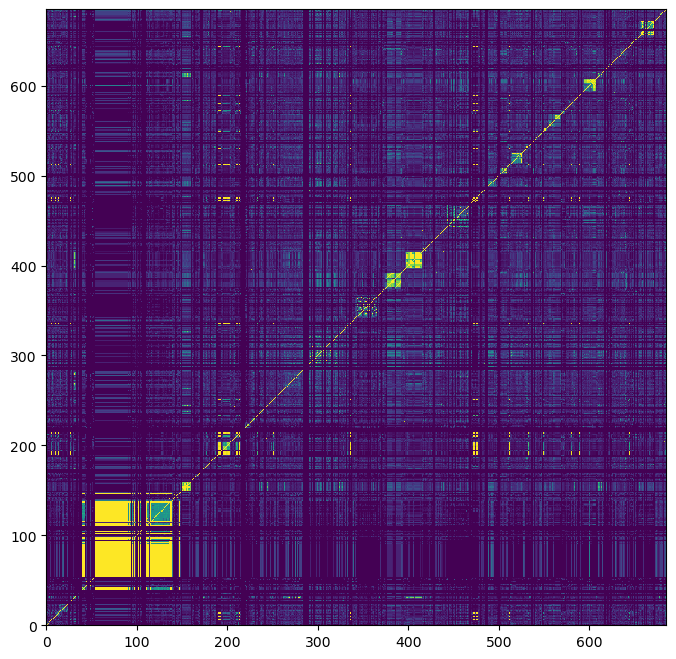

In [319]:
figure = plt.figure(figsize=(8,8))
plt.pcolor(wind_pars_linear_sum)
#plt.savefig('./results/wind_pars_common_rows_cols_overall.png';

In [41]:
df_pars_sim_75, new_sim_75 = get_max_sim_comds(wind_pars_linear_sum, 0.75)
pars_sim_score_df = create_matrix_high_sim_comds(wind_pars_linear_sum,df_pars_sim_75)
#plot_sim_heatmap(pars_sim_score_df)

In [42]:
new_sim_75

{'assign': ['convert basic',
  'convert dynamic',
  'convert gpt',
  'convert mbr',
  'delete volume',
  'detach vdisk',
  'import (diskpart)',
  'offline disk',
  'offline volume',
  'online disk',
  'online volume',
  'recover disk group'],
 'attach-vdisk': ['convert basic',
  'convert dynamic',
  'convert gpt',
  'convert mbr',
  'delete volume',
  'detach vdisk',
  'import (diskpart)',
  'offline disk',
  'offline volume',
  'online disk',
  'online volume',
  'recover disk group'],
 'attributes disk': ['attributes volume',
  'convert basic',
  'convert dynamic',
  'convert gpt',
  'convert mbr',
  'delete volume',
  'detach vdisk',
  'import (diskpart)',
  'offline disk',
  'offline volume',
  'online disk',
  'online volume',
  'recover disk group'],
 'attributes volume': ['convert basic',
  'convert dynamic',
  'convert gpt',
  'convert mbr',
  'delete volume',
  'detach vdisk',
  'import (diskpart)',
  'offline disk',
  'offline volume',
  'online disk',
  'online volume',
  'r

In [43]:
new_sim_75['del']

['erase']

In [44]:
comm1_unique = list((df_pars_sim_75['comm1'].unique()))
comm2_unique = list((df_pars_sim_75['comm2'].unique()))
for cmd in comm2_unique:
    if cmd not in comm1_unique:
        comm1_unique.append(cmd)
new = wind_pars_linear_sum.loc[comm1_unique]

In [323]:
fig = ff.create_dendrogram(new,  labels=new.index)
fig.update_layout(width=1600, height=800)
fig.write_image('./results/windows/wind_pars_dendo_high_sim.png')
fig.show()

In [324]:
new

,active,add,add alias,add volume,append,arp,assign,assoc,at,atmadm,...,where,whoami,winnt32,winrs,winsat mem,winsat mfmedia,wmic,writer,wscript,xcopy
assign,0,0.0943,0.0000,0.0993,0.1229,0.0366,1.0000,0.0000,0.1749,0.0493,...,0.1124,0.0321,0.3764,0.0727,0.1104,0.1286,0.0429,0.0000,0.1356,0.3623
attach-vdisk,0,0.0342,0.1423,0.0858,0.0881,0.0426,0.3356,0.1615,0.0896,0.0472,...,0.0876,0.0933,0.1174,0.1170,0.1308,0.1388,0.0686,0.0694,0.1398,0.2930
attributes disk,0,0.0931,0.1565,0.1158,0.1798,0.0113,0.3333,0.1375,0.0665,0.0112,...,0.0623,0.0357,0.1356,0.1168,0.1174,0.1330,0.0361,0.0631,0.1011,0.3720
attributes volume,0,0.3538,0.1330,0.4118,0.1411,0.0090,0.4816,0.1182,0.0711,0.0120,...,0.0459,0.0245,0.1703,0.0970,0.0986,0.1086,0.0599,0.0507,0.0863,0.3676
automount,0,0.1523,0.0000,0.1092,0.0671,0.0142,0.6092,0.0000,0.0696,0.0464,...,0.0329,0.0262,0.2077,0.0673,0.0903,0.1095,0.0364,0.0180,0.0851,0.2233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subcommand stop transportserver,0,0.0000,0.1531,0.1092,0.1541,0.0558,0.0469,0.1201,0.1651,0.0328,...,0.1001,0.3111,0.1443,0.2107,0.0897,0.1052,0.0000,0.0716,0.1144,0.1931
vssadmin list shadows,0,0.2621,0.0977,0.4315,0.2085,0.0345,0.1023,0.1028,0.0832,0.0000,...,0.1088,0.1173,0.0993,0.0905,0.1369,0.1263,0.0308,0.0420,0.0943,0.2061
wbadmin stop job,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2246,0.0000,...,0.0000,0.1329,0.1494,0.1639,0.1269,0.1468,0.0000,0.0000,0.2918,0.1665
wbadmin get versions,0,0.0350,0.0934,0.1204,0.1863,0.0548,0.0987,0.0757,0.2204,0.0822,...,0.0929,0.0602,0.1830,0.1362,0.1418,0.1539,0.0000,0.1271,0.1241,0.2341


In [45]:
def cal_histo(new_sim):
    G = nx.Graph()
    for key, value in new_sim.items():
        for v in value:
            G.add_edge(key,v)
    subgraphs =  list(nx.connected_components(G))
    new = dict()
    for i in range(len(subgraphs)):
        new[next(iter(subgraphs[i]))] = len(subgraphs[i])
    new = {k: v for k, v in sorted(new.items(), key=lambda item: item[1],reverse=True)} 
    return subgraphs, new
           

In [46]:
subgraphs, new = cal_histo(new_sim_75)

In [47]:
subgraphs

[{'assign',
  'attach-vdisk',
  'attributes disk',
  'attributes volume',
  'automount',
  'convert basic',
  'convert dynamic',
  'convert gpt',
  'convert mbr',
  'create partition efi',
  'create partition logical',
  'create partition msr',
  'create partition primary',
  'create volume mirror',
  'create volume raid',
  'create volume simple',
  'create volume stripe',
  'delete disk',
  'delete partition',
  'delete volume',
  'detach vdisk',
  'extend',
  'import (diskpart)',
  'offline disk',
  'offline volume',
  'online disk',
  'online volume',
  'recover disk group',
  'remove',
  'repair',
  'san',
  'select vdisk',
  'set id',
  'shrink',
  'uniqueid'},
 {'bdehdcfg driveinfo',
  'chkdsk',
  'fsutil file',
  'fsutil fsinfo',
  'fsutil resource',
  'fsutil usn',
  'fsutil volume',
  'manage bde autounlock',
  'manage bde changekey',
  'manage bde changepassword',
  'manage bde changepin',
  'manage bde forcerecovery',
  'manage bde keypackage',
  'manage bde lock',
  'manag

In [48]:
new

{'bitsadmin getmodificationtime': 76,
 'shrink': 35,
 'manage bde unlock': 24,
 'bootcfg raw': 19,
 'logman create api': 14,
 'subcommand set multicasttransmission': 13,
 'reg restore': 10,
 'wbadmin start systemstatebackup': 10,
 'ftp get': 7,
 'ksetup delenctypeattr': 5,
 'nslookup set': 5,
 'secedit export': 5,
 'ksetup addkpasswd': 4,
 'query user': 4,
 'ftp delete': 3,
 'ksetup delhosttorealmmap': 3,
 'sc create': 3,
 'wbadmin get versions': 3,
 'bitsadmin cache and delete': 2,
 'bitsadmin util and getieproxy': 2,
 'cscript': 2,
 'del': 2,
 'dfsdiag testdfsconfig': 2,
 'diantz': 2,
 'ftp ls': 2,
 'ftp quote': 2,
 'logoff': 2,
 'mapadmin': 2,
 'mkdir': 2,
 'nslookup set type': 2,
 'online': 2,
 'rd': 2,
 'rename': 2,
 'scwcmd configure': 2,
 'start': 2,
 'vssadmin delete shadows': 2}

In [52]:
new['bitsadmin *'] = new.pop('bitsadmin getmodificationtime')
new['disk, partition, volume'] = new.pop('shrink')
new['manage bde *'] = new.pop('manage bde unlock')
new['bootcfg *'] = new.pop('bootcfg raw')
new['logman *'] = new.pop('logman create api')
new['subcommand *'] = new.pop('subcommand set multicasttransmission')
new['reg *'] = new.pop('reg restore')
new['ftp put, recv, send, get'] = new.pop('ftp get')
new['wbadmin *'] = new.pop('wbadmin start systemstatebackup')
new['ksetup *enctypeattr'] = new.pop('ksetup delenctypeattr')
new['nslookup *'] = new.pop('nslookup set')
new['secedit *'] = new.pop('secedit export')

new

{'ksetup addkpasswd': 4,
 'query user': 4,
 'ftp delete': 3,
 'ksetup delhosttorealmmap': 3,
 'sc create': 3,
 'wbadmin get versions': 3,
 'bitsadmin *': 76,
 'disk, partition, volume': 35,
 'manage bde *': 24,
 'bootcfg *': 19,
 'logman *': 14,
 'subcommand *': 13,
 'reg *': 10,
 'ftp put, recv, send, get': 7,
 'wbadmin *': 10,
 'ksetup *enctypeattr': 5,
 'nslookup *': 5,
 'secedit *': 5}

In [71]:

new['ksetup removerealm'] = new.pop('ksetup delhosttorealmmap')

In [76]:
new = {k: v for k, v in sorted(new.items(), key=lambda item: item[1],reverse=True)} 
new = {key:val for key, val in new.items() if val >4}
new

{'bitsadmin *': 76,
 'disk, partition, volume': 35,
 'manage bde *': 24,
 'bootcfg *': 19,
 'logman *': 14,
 'subcommand *': 13,
 'reg *': 10,
 'ftp put, recv, send, get': 7,
 'ksetup *enctypeattr': 5,
 'nslookup *': 5,
 'secedit *': 5}

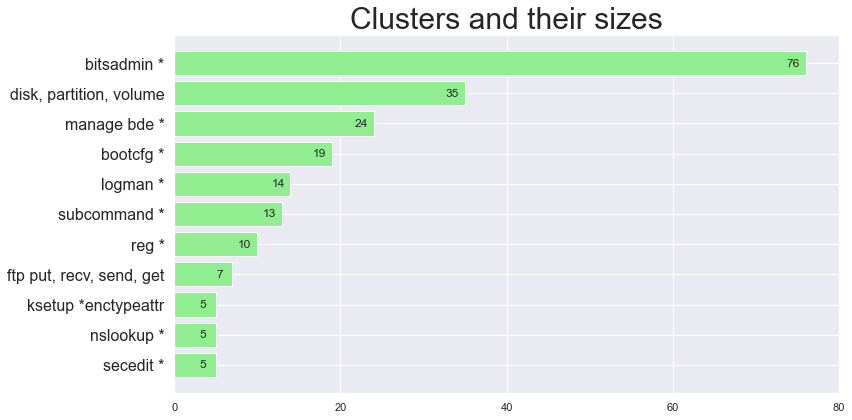

In [93]:
import seaborn as sns
sns.set()
fig= plt.figure(figsize=(12,6))

x = list(new.values())
y = list(new.keys())
ax = plt.barh( y,x,  color='lightgreen', align='center')
plt.xticks()

plt.yticks(rotation='horizontal',fontsize = 16 )
plt.title('Clusters and their sizes', fontsize = 30)
for p in ax.patches:
    width = p.get_width()
    plt.text(-1.5+p.get_width(), p.get_y()+0.50*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')
#for i in range(len(y)):
#    if i==0:
#         plt.annotate(str(x[i]), xy=(x[i],y[i]), ha='center', va='top', rotation=90, fontsize=24)
    #elif i ==1:
    #     plt.annotate(str(x[i]), xy=(x[i],y[i]), ha='center', va='center', rotation=90, fontsize=24)
    #else:
    #    plt.annotate(str(x[i]), xy=(x[i],y[i]), ha='center', va='bottom', rotation=90, fontsize=24)

plt.xticks([0,  20,  40,  60,  80])
plt.gca().invert_yaxis()
plt.tight_layout()
#plt.savefig('./results/windows/windows_pars_histogram.png')
plt.show()

In [65]:
y

[76, 35, 24, 19, 14, 13, 10, 10, 7, 5, 5, 5, 4, 4, 3, 3, 3, 3]

In [294]:
new_sim_75['nslookup server']

['nslookup set']

In [2]:
wind_pars_linear_sum = pd.read_csv('./data/windows/windows_pars_sim_df.csv', index_col=0)

In [3]:
wind_pars_linear_sum

,active,add,add alias,add volume,append,arp,assign,assoc,at,atmadm,...,where,whoami,winnt32,winrs,winsat mem,winsat mfmedia,wmic,writer,wscript,xcopy
active,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
add,0,1.0000,0.1979,0.3914,0.0713,0.0772,0.0943,0.0000,0.0305,0.0000,...,0.0200,0.0424,0.0607,0.0837,0.1656,0.1551,0.0632,0.0000,0.0138,0.1292
add alias,0,0.1979,1.0000,0.0833,0.1960,0.0257,0.0000,0.1965,0.0868,0.0000,...,0.1222,0.2092,0.1678,0.1395,0.2880,0.1460,0.1874,0.0917,0.1060,0.1884
add volume,0,0.3914,0.0833,1.0000,0.1438,0.0693,0.0993,0.0732,0.0593,0.0198,...,0.0925,0.0659,0.2524,0.1124,0.1308,0.1471,0.0177,0.0340,0.1042,0.1906
append,0,0.0713,0.1960,0.1438,1.0000,0.0299,0.1229,0.2461,0.0605,0.0000,...,0.1602,0.0284,0.1585,0.1274,0.0797,0.0899,0.0314,0.0849,0.1483,0.2190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
winsat mfmedia,0,0.1551,0.1460,0.1471,0.0899,0.0516,0.1286,0.2608,0.0897,0.0998,...,0.1261,0.0632,0.1277,0.0772,0.5852,1.0000,0.1141,0.1213,0.1284,0.1338
wmic,0,0.0632,0.1874,0.0177,0.0314,0.0380,0.0429,0.0000,0.0364,0.0887,...,0.0751,0.0745,0.0855,0.0880,0.0915,0.1141,1.0000,0.0000,0.1204,0.1124
writer,0,0.0000,0.0917,0.0340,0.0849,0.0125,0.0000,0.0781,0.0346,0.0000,...,0.0675,0.0822,0.0584,0.0529,0.1124,0.1213,0.0000,1.0000,0.0414,0.1445
wscript,0,0.0138,0.1060,0.1042,0.1483,0.0389,0.1356,0.5068,0.1261,0.1213,...,0.1990,0.1072,0.1790,0.1108,0.1320,0.1284,0.1204,0.0414,1.0000,0.1274


In [10]:
wind_pars_linear_sum.to_excel('./data/windows/windows_pars_sim_df.xlsx')

In [25]:
with open("./data/windows/windows_pars_sim.txt", "w") as fp:
    json.dump(new_sim_75, fp)

In [26]:
import json

# Serialize data into file:
json.dump( new_sim_75, open( "./data/windows/windows_pars_sim.json", 'w' ) )

In [95]:
score_cell={}
for key, value in new_sim_75.items():
    temp = {}
    for v in value:
        score = wind_pars_linear_sum[key][v]
        temp[v]=score
    score_cell[key]=temp

In [97]:
import json

# Serialize data into file:
json.dump( score_cell, open( "./data/windows/score_cell.json", 'w' ) )

In [101]:
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

In [102]:
csv_dict = nested_dict_to_df(score_cell)

In [116]:
csv_dict = pd.DataFrame(score_cell,columns = ['cmd1', 'cmd2', 'score'])

In [ ]:
for score_cell.items()

In [130]:
new_list = []
for k, v in score_cell.items():
    for value in v:
        new_list.append([k, value, score_cell[k][value]])

In [131]:
csv_dict = pd.DataFrame(new_list, columns=['cmd1', 'cmd2', 'score'])

In [134]:
csv_dict.to_csv('./data/windows/graph.csv', index=False)

In [138]:
csv_dict['score'].dtype

dtype('float64')